# Covid-19 Data Analysis

This project consists of exploring Covid-19 data. The current pandemic has resulted in a need for a better understanding of infectious diseases and how they spread. This lends itself well to data science which has the necessary tools needed to analyse data of this kind in numerous ways. This project aims to perform time-series analysis on Covid-19 data from numerous countries to create predictions on how many Covid-19 cases there will be in the future. It will begin by introducing the data set and discussing some limitations and will then move on to some data manipulation necessary for time series analysis. Then time series analysis will be performed to create predictions for a chosen country.

### The Data

The data used in this project was obtained from John Hopkins University and is composed of Covid-19 cases for particular dates in numerous countries across the world. It also contains the latitude and longitude of each country. Note that this data does not contain information on deaths from Covid or the number of vaccinations, which means that analysis on this data will only be able to predict how cases will rise in the absence of vaccination programmes in all countries.

In [1]:
import pandas as pd

global_data = pd.read_csv('covid_cases.csv')

global_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21\
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,154960,154960,154960,155072,155093,155128,155174,155191,155191,155191\
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,166690,167354,167893,168188,168782,169462,170131,170778,171327,171794\
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,202449,202574,202722,202877,203045,203198,203359,203517,203657,203789\
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15167,15167,15167,15189,15192,15209,15222,15222,15222,15222\
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,54280,54795,55121,55583,56040,56583,56583,58076,58603,58943\


Some countries are split into different provinces. To stop this from interfering with analysis they will be aggregated into their respective countries. The Province/State column will now be meaningless so will be removed. The Lat and Long columns will also be removed as geographical analysis is not necessary for this project.

In [2]:
global_data_summed = global_data.groupby('Country/Region').sum()

df = global_data_summed.drop(['Lat', 'Long'], axis=1).reset_index() # Doesn't make sense to keep Lat/Long after dataframe has been summed
df.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,154800,154960,154960,154960,155072,155093,155128,155174,155191,155191
1,Albania,0,0,0,0,0,0,0,0,0,...,165864,166690,167354,167893,168188,168782,169462,170131,170778,171327
2,Algeria,0,0,0,0,0,0,0,0,0,...,202283,202449,202574,202722,202877,203045,203198,203359,203517,203657
3,Andorra,0,0,0,0,0,0,0,0,0,...,15156,15167,15167,15167,15189,15192,15209,15222,15222,15222
4,Angola,0,0,0,0,0,0,0,0,0,...,53840,54280,54795,55121,55583,56040,56583,56583,58076,58603


It is also useful to plot some visualisations of the data before performing in-depth analysis as this gives a general idea of what the data looks like and indicates whether the chosen form of analysis is suitable. Covid cases over time will be visualised from five randomly chosen countries.

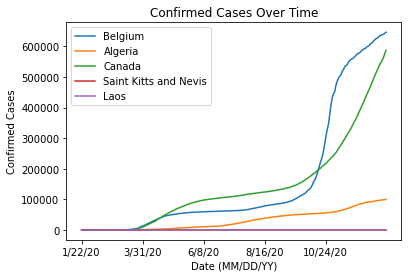

In [5]:
import random
import matplotlib.pyplot as plt
import datetime

chosen_countries = random.sample(list(df['Country/Region'].unique()), 5)

# Chosen dates to visualise US Date format: 'MM/DD/YYYY'
start_date = '01/22/2020'
end_date = '12/31/2020'

# Function used to pull start and finish index for the chosen countires to make plotting easier
def get_index_from_date(date_string):
    FIRST_DATE = datetime.datetime(2020, 1, 22)
    
    date_list = [int(x) for x in date_string.split('/')]
    date_object = datetime.datetime(date_list[-1], date_list[0], date_list[1])
    
    return (date_object-FIRST_DATE).days

dates = list(df)[1:]

start_index = get_index_from_date(start_date)
end_index = get_index_from_date(end_date)

x_values = dates[start_index:end_index+1]

# Plot covid levels for each country on the same graph
for country in chosen_countries:
    country_df = df[df['Country/Region'] == country]
    y_values = [int(country_df[col]) for col in x_values]
    plt.plot(x_values, y_values, label=country)
    
plt.title('Confirmed Cases Over Time')
skip = max(len(x_values)//5, 1) # stops too many date tick marks from being added
plt.xticks(x_values[::skip])
plt.xlabel("Date (MM/DD/YY)")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

There are clear patterns in the above data visualisations that imply that time series analysis will be able to identify features that can be used for predictive analysis.

### Time Series Analysis

In this section time-series analysis will be performed for a chosen country in the data frame. The chosen method of analysis is the AutoRegressive Integrated Moving Average (ARIMA). This is a commonly used model in time series forecasting. The parameters in the ARIMA model are:
 - p, the number of lag observations included
 - d, degree of differencing
 - q, size of moving average window

In [6]:
# Country chosen for time series analysis
country = 'United Kingdom'
# Create list of all countries in data frame
country_list = list(df['Country/Region'].unique())
# Pull index of chosen country
country_index = country_list.index(country)
# Pull covid levels from chosen country
country_cases = df.iloc[country_index]

These parameters in the ARIMA model are mainly fine-tuned through experimentation but the number of lag observations, p, can be estimated using an autocorrelation plot of the time series. This is done by observing how many lags there are with a significant positive correlation, which is commonly denoted by a correlation of 0.75 or above. There is a built-in function in python for autocorrelation plots.

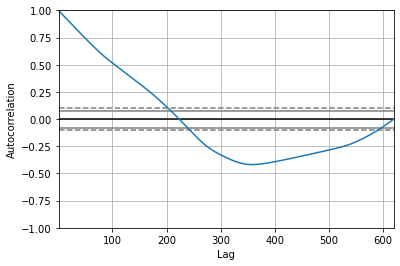

In [7]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

# Autocorrelation plot
autocorrelation_plot(country_cases[1:])
pyplot.show()

As shown in the above graph, there is a significant positive correlation for approximately the first 50 lags, so the parameter p can be chosen as any number <50.

The ARIMA model is now fitted to the data and the resulting errors are analysed to get an idea of how well this type of model can describe the data. The chosen parameters for p, d and q are 50, 1 and 10 respectively.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


                               SARIMAX Results                                
Dep. Variable:                    185   No. Observations:                  620
Model:               ARIMA(50, 1, 10)   Log Likelihood               -5645.470
Date:                Sun, 10 Oct 2021   AIC                          11412.939
Time:                        18:07:08   BIC                          11683.054
Sample:                    01-22-2020   HQIC                         11517.942
                         - 10-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5765      0.934      0.617      0.537      -1.255       2.407
ar.L2          0.4755      0.760      0.626      0.532      -1.014       1.965
ar.L3          0.1704      0.713      0.239      0.8

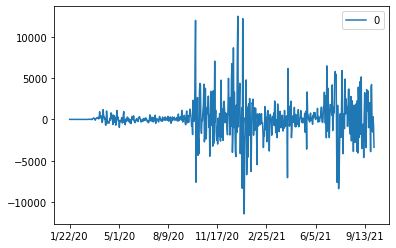

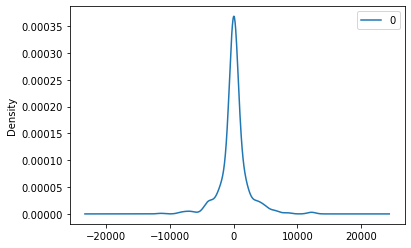

                  0
count    620.000000
mean      87.190469
std     2186.989175
min   -11434.489225
25%     -420.226283
50%        0.827297
75%      517.938613
max    12475.898301


In [8]:
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(country_cases[1:].astype(float), order=(50,1,10))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Fitting the ARIMA model to the data results in a table displaying a series of statistics relating to the data as well as two graphs and then a smaller table at the bottom. The first graph details the residual errors of each data point generated by the model compared to each data point in the model. The highest error was around 10,000. In the context of covid levels in the UK, which are in the millions, this is not a particularly high error and suggests that the model is able to accurately describe the data.
<br>
The second graph is a density plot of the residual errors and shows that the distribution of the error is a normal distribution which is roughly centred around 0. The smaller table at the end provides further information on the residual errors and shows that the mean of the errors is 87.19. This suggests that the model is very slightly more prone to overestimating covid levels rather than underestimating them.

Now the ARIMA model is used to make predictions on unseen data which is then compared to the actual data. First, the data is split into training and test sets. The model will learn the behaviour of the data in the training set and use this information to make predictions on the test set. A common percentage split between training and test sets is 66/33 respectively. As future levels are dependent on previous levels a rolling forecast must be created. This can be done by re-creating the ARIMA model after each new observation is taken into account. Previous observations in the test set are then stored in a list called history. Due to computational limitations, a smaller number of lags are included as the ARIMA model has to be fitted after each iteration. The moving window value is also changed to improve computation time. The parameter values used for the ARIMA model for each value in the training set will be p=5, d=1 and q=0. The Root Mean Squared Error (RMSE) is then used to evaluate the performance of the model on the test data.

In [10]:
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Data is split into train and test sets
X = country_cases[1:].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred = output[0]
    predictions.append(pred)
    obs = test[t]
    history.append(obs)
print(f'predicted={pred}', f'expected={obs}')
# Evaluate predictions
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE={rmse}')


<ipython-input-10-3786a28aac5b>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


predicted=7913684.6687921025 expected=7908091
Test RMSE: 2724.515


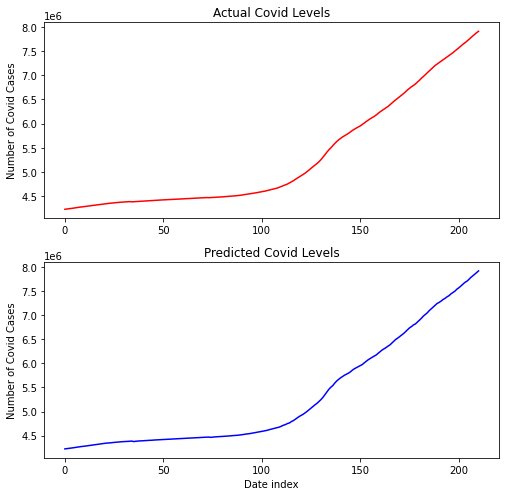

In [23]:
# Plotting predictions and actual covid levels for comparison
plt.figure(figsize=(7,7))

plt.subplot(2, 1, 1)
plt.plot(test, color='red')
plt.title('Actual Covid Levels')
plt.ylabel('Number of Covid Cases')


plt.subplot(2, 1, 2)
plt.plot(predictions, color='blue')
plt.title('Predicted Covid Levels')
plt.xlabel('Date index')
plt.ylabel('Number of Covid Cases')

plt.tight_layout()
plt.show()

As shown by the above graphs, the predictions made by the ARIMA model closely resemble the actual covid levels. Furthermore, the overall  Root Mean Squared Error, RMSE, on the test set was recorded as 2724.515 which when compared to the numbers being dealt with (covid cases in the UK are in the millions) is relatively low. This indicates that this model is perfectly capable of making predictions on future covid levels if deaths and vaccinations are not taken into account.